In [3]:
import PIL as pil
from matplotlib import pyplot as plt
import numpy as np
import math
from datetime import datetime
import cv2

In [4]:
def img2array(img):
    nrow = img.size[1]
    ncol = img.size[0]
    img_map = img.load()
    myarray = np.zeros([nrow,ncol,3], dtype=np.uint8)
    for i in range(nrow):
        for j in range(ncol):
            myarray[i,j,0] = img_map[j,i][0]
            myarray[i,j,1] = img_map[j,i][1]
            myarray[i,j,2] = img_map[j,i][2]
    return myarray

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def imgthreshold(gray, thres):
    nrow = gray.shape[0]
    ncol = gray.shape[1]
    output = np.zeros([nrow,ncol], dtype=np.uint8)
    for i in range(nrow):
        for j in range(ncol):
            if gray[i,j] > thres:
                output[i,j] = 255
    return output

# Try to get the rectangle surrounding the objects
def getRecs(thresimg, max_obj_width, max_obj_height):

    x, y = [], []
    minx = []
    maxx = []
    miny = []
    maxy = []

    nR, nC = thresimg.shape

#     print("nR: ", nR)
#     print("nC: ", nC)

    for i in range(nR):
        for j in range(nC):
            if np.abs(thresimg[i,j]) > 200:
                x.append(j)
                y.append(i)
            
#     print("len(x): ", len(x))


    tmpx = np.copy(x)
    tmpy = np.copy(y)

    count = 1

    while len(tmpx)>0:
    # for k in range(1):

#         print("count: ", count)
    
        current_maxx = tmpx[0]
        current_maxy = tmpy[0]
        current_minx = tmpx[0]
        current_miny = tmpy[0]
    
        current_x = tmpx[0]
        current_y = tmpy[0]
    
#         print("current_maxx: ", current_maxx)
#         print("current_minx: ", current_minx)
#         print("current_maxy: ", current_maxy)
#         print("current_miny: ", current_miny) 
    
        # get the maxx
        j_max = min (nC, current_x + int(max_obj_width/2)) - current_x
        for j in range(j_max):
            isfound = 0  
            for i in range(-int(max_obj_height/2),int(max_obj_height/2)):
                if current_y + i >= 0 and current_y + i < nR and thresimg[current_y + i, current_x + j] > 200:
                    isfound = 1
                    break
            if isfound == 0:
#                 print("j: ", j)
                current_maxx = current_maxx + j
                break
            elif isfound == 1 and j == j_max - 1:
#                 print("j: ", j)
                current_maxx = current_maxx + j
            
    
        # get the min x
        j_max = current_x - max(0, current_x - int(max_obj_width/2))
        for j in range(j_max):
            isfound = 0
            for i in range(-int(max_obj_height/2),int(max_obj_height/2)):
                if current_y + i >= 0 and current_y + i < nR and thresimg[current_y + i, current_x - j] > 200:
                    isfound = 1
                    break
            if isfound == 0:
#                 print("j: ", j)
                current_minx = current_minx - j
                break
            elif isfound == 1 and j == j_max - 1:
#                 print("j: ", j)
                current_minx = current_minx - j
    
    
        # get the maxy
        i_max = min(nR, current_y + int(max_obj_height/2)) - current_y
        for i in range(i_max):
            isfound = 0
            for j in range(-int(max_obj_width/2),int(max_obj_width/2)):
                if  current_x + j >= current_minx and current_x + j < current_maxx and thresimg[current_y + i, current_x + j] > 200:
                    isfound = 1
                    break
            if isfound == 0:
#                 print("i: ", i)
                current_maxy = current_maxy + i
                break
            elif isfound == 1 and i == i_max - 1:
#                 print("i: ", i)
                current_maxy = current_maxy + i
        
        
        # get the miny
        i_max = current_y - max(0, current_y - int(max_obj_height/2))
        for i in range(i_max):
            isfound = 0
            for j in range(-int(max_obj_width/2),int(max_obj_width/2)):
                if current_x + j >= current_minx and current_x + j < current_maxx and thresimg[current_y - i, current_x + j] > 200:
                    isfound = 1
                    break
            if isfound == 0:
#                 print("i: ", i)
                current_miny = current_miny - i
                break
            elif isfound == 1 and i == int(max_obj_height/2) - 1:
#                 print("i: ", i)
                current_miny = current_miny - i
    
    
#         print("current_maxx: ", current_maxx)
#         print("current_minx: ", current_minx)
#         print("current_maxy: ", current_maxy)
#         print("current_miny: ", current_miny)
    
        minx.append(current_minx)
        maxx.append(current_maxx)
        miny.append(current_miny)
        maxy.append(current_maxy)
    
        # Remove the current object
        newx = []
        newy = []
    
        for i in range(len(tmpx)):
            if tmpx[i] > current_maxx or tmpx[i] < current_minx or tmpy[i] > current_maxy or tmpy[i] < current_miny:
                newx.append(tmpx[i])
                newy.append(tmpy[i])
            
        tmpx = newx
        tmpy = newy
    
#         print("new len: ", len(newx))
        count = count + 1


# plt.imshow(orig1_rgb)
# plt.autoscale(False)
# plt.plot(x,y, 'ro')

    return minx, maxx, miny, maxy

def filterUsingWidthHeightRatio(minx, maxx, miny, maxy, ratio_min, ratio_max):
    outminx = []
    outmaxx = []
    outminy = []
    outmaxy = []
    
    for i in range(len(minx)):
        deltax = maxx[i] - minx[i]
        deltay = maxy[i] - miny[i]
        if deltax/deltay > ratio_min and deltax/deltay < ratio_max:
            outminx.append(minx[i])
            outmaxx.append(maxx[i])
            outminy.append(miny[i])
            outmaxy.append(maxy[i])
            
        
    return outminx, outmaxx, outminy, outmaxy

def filterUsingSize(minx, maxx, miny, maxy, thres_size):
    outminx = []
    outmaxx = []
    outminy = []
    outmaxy = []
    
    for i in range(len(minx)):
        deltax = maxx[i] - minx[i]
        deltay = maxy[i] - miny[i]
        if deltax > thres_size or deltay > thres_size:
            outminx.append(minx[i])
            outmaxx.append(maxx[i])
            outminy.append(miny[i])
            outmaxy.append(maxy[i])
            
        
    return outminx, outmaxx, outminy, outmaxy

def couplingLightCandidates(minx, maxx, miny, maxy, diffy_tol):
    not_coupling = []
    coupling_list = []
    for i in range(len(minx)):
        not_coupling.append(i)
       
    while len(not_coupling) > 1:
        target_idx = not_coupling[0]
        caldidate_idx = not_coupling[1]
        couple_idx  = caldidate_idx
        targetmidy = (maxy[target_idx] + miny[target_idx])/2
        caldidatemidy = (maxy[caldidate_idx] + miny[caldidate_idx])/2
        diffy = abs(caldidatemidy - targetmidy)
#         print("target_idx: ", target_idx)
#         print("caldidate_idx: ", couple_idx)
#         print("diffy: ", diffy)
        if len(not_coupling) > 2:
            for j in range(2,len(not_coupling)):
                caldidate_idx = not_coupling[j]
                caldidatemidy = (maxy[caldidate_idx] + miny[caldidate_idx])/2
#                 print("j: ", j)
#                 print("target_idx: ", target_idx)
#                 print("caldidate_idx: ", couple_idx)
#                 print("diffy: ", abs(caldidatemidy - targetmidy))
                if abs(caldidatemidy - targetmidy) < diffy:
                    diffy = abs(caldidatemidy - targetmidy) 
                    couple_idx = caldidate_idx
            
        new_not_coupling = []
        
        if diffy > diffy_tol:
            for j in range(len(not_coupling)):
                if not_coupling[j] != target_idx:
                    new_not_coupling.append(not_coupling[j])
        else:
            coupling_list.append((target_idx, couple_idx))
            for j in range(len(not_coupling)):
                if not_coupling[j] != target_idx  and not_coupling[j] != couple_idx:
                    new_not_coupling.append(not_coupling[j])        
        
                
        not_coupling = new_not_coupling
                
        
    return coupling_list

def getCouplingList(myminx, mymaxx, myminy, mymaxy, mycoupling_list, y_tol, y_ratmin, y_ratmax, x_ratmin, x_ratmax):
    outputCouplingList = []
    for i in range(len(mycoupling_list)):
        target_idx, couple_idx = mycoupling_list[i]
        print( target_idx , " " , couple_idx)
        targetmidy = (mymaxy[target_idx] + myminy[target_idx])/2
        couplemidy = (mymaxy[couple_idx] + myminy[couple_idx])/2
        diffy = abs(couplemidy - targetmidy)
        targetdeltax = mymaxx[target_idx] - myminx[target_idx]
        coupledeltax = mymaxx[couple_idx] - myminx[couple_idx]
        targetdeltay = mymaxy[target_idx] - myminy[target_idx]
        coupledeltay = mymaxy[couple_idx] - myminy[couple_idx]
        print("targetmaxy: ", mymaxy[target_idx])
        print("targetminy: ", myminy[target_idx])
        print("couplemaxy: ", mymaxy[couple_idx])
        print("coupleminy: ", myminy[couple_idx])
        print("diffy: ", diffy)
        print("targetdeltax: ", targetdeltax)
        print("targetdeltay: ", targetdeltay)       
        print("coupledeltax: ", coupledeltax)
        print("coupledeltay: ", coupledeltay)
        
        if diffy < y_tol and coupledeltax/targetdeltax > x_ratmin and coupledeltax/targetdeltax < x_ratmax and coupledeltay/targetdeltay > y_ratmin and coupledeltay/targetdeltay < y_ratmax:
            outputCouplingList.append(mycoupling_list[i])
            
    return outputCouplingList

def getCoupleRecs(myminx, mymaxx, myminy, mymaxy, mycoupling_list):
    outminx = []
    outmaxx = []
    outminy = []
    outmaxy = []
    for i in range(len(mycoupling_list)):
        target_idx, couple_idx = mycoupling_list[i]
        outminx.append(min(myminx[target_idx], myminx[couple_idx]))
        outmaxx.append(max(mymaxx[target_idx], mymaxx[couple_idx]))
        outminy.append(min(myminy[target_idx], myminy[couple_idx]))
        outmaxy.append(max(mymaxy[target_idx], mymaxy[couple_idx]))
        
    return outminx, outmaxx, outminy, outmaxy
        

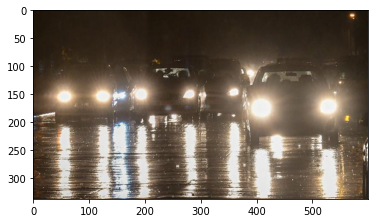

In [5]:
# vehicle-lights-1-1541743976.jpg
orig1 = cv2.imread("../Image/vehicle-lights-1-1541743976.jpg")
orig1_rgb = cv2.cvtColor(orig1, cv2.COLOR_BGR2RGB)

plt.imshow(orig1_rgb)


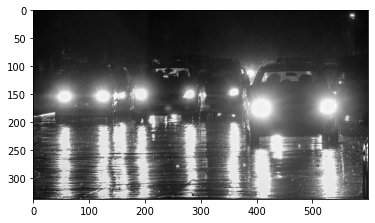

In [6]:
grayscale = cv2.cvtColor(orig1_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(grayscale, cmap='gray')

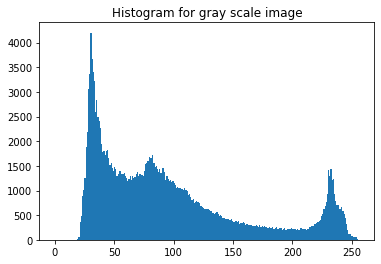

In [7]:
dst = cv2.calcHist(grayscale, [0], None, [256], [0,256])

plt.hist(grayscale.ravel(),256,[0,256])
plt.title('Histogram for gray scale image')
plt.show()

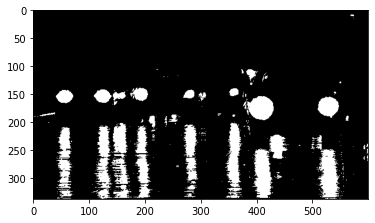

In [8]:
thresimg = imgthreshold(grayscale, 200)
plt.imshow(thresimg, cmap='gray')

In [9]:
# Finding the squares
myminx, mymaxx, myminy, mymaxy = getRecs(thresimg, 70, 150)
# filter using ratio
myminx, mymaxx, myminy, mymaxy = filterUsingWidthHeightRatio(myminx, mymaxx, myminy, mymaxy, 0.8, 1.5)
# filter using size
myminx, mymaxx, myminy, mymaxy = filterUsingSize(myminx, mymaxx, myminy, mymaxy, 8)
# Coupling the 

/tmp/ipykernel_21336/3089949315.py:185: RuntimeWarning: divide by zero encountered in long_scalars
  if deltax/deltay > ratio_min and deltax/deltay < ratio_max:


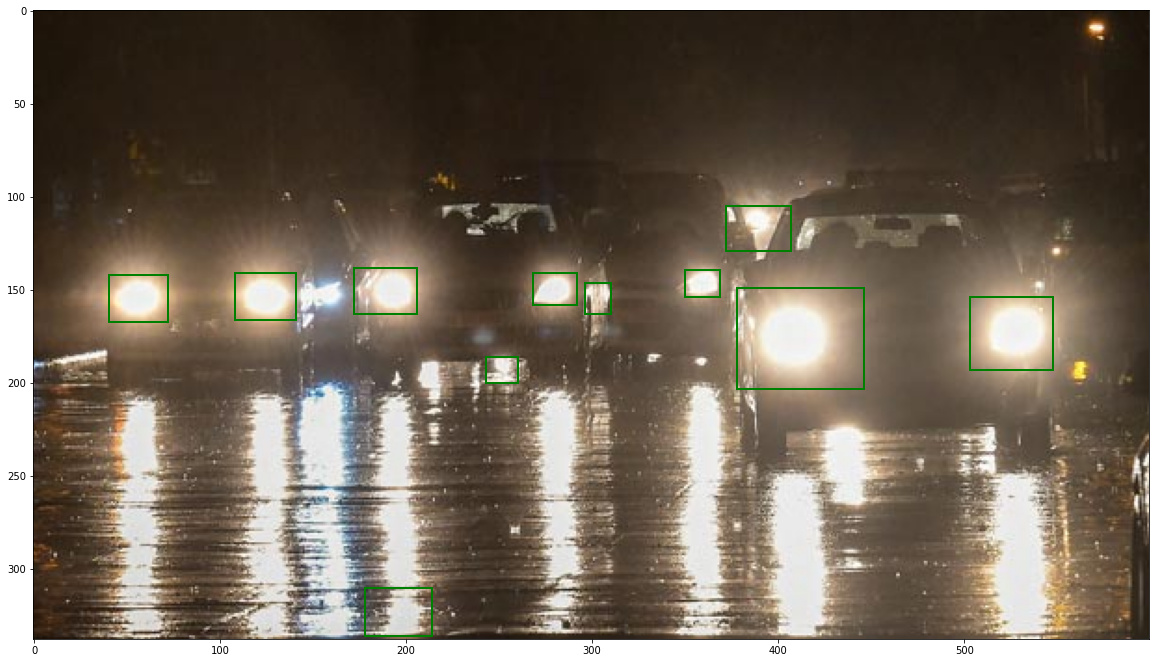

In [10]:
import matplotlib
f, axarr = plt.subplots(1,1, figsize=(20, 20))
axarr.imshow(orig1_rgb)
for i in range(len(myminx)):
    current_minx = myminx[i]
    current_maxx = mymaxx[i]
    current_miny = myminy[i]
    current_maxy = mymaxy[i]
    delta_x = current_maxx - current_minx
    delta_y = current_maxy - current_miny
    axarr.add_patch( matplotlib.patches.Rectangle((current_minx, current_miny), delta_x, delta_y, fc ='none', ec='g', lw = 2))

In [18]:
# Get the coupling candidate
mycoupling_list = couplingLightCandidates(myminx, mymaxx, myminy, mymaxy, 5)
# Validate using rules
getCouplingList(myminx, mymaxx, myminy, mymaxy, mycoupling_list, 5, 0.3, 1.8, 0.3, 1.8)

1   4
targetmaxy:  163
targetminy:  138
couplemaxy:  158
coupleminy:  141
diffy:  1.0
targetdeltax:  34
targetdeltay:  25
coupledeltax:  24
coupledeltay:  17
3   5
targetmaxy:  166
targetminy:  141
couplemaxy:  167
coupleminy:  142
diffy:  1.0
targetdeltax:  33
targetdeltay:  25
coupledeltax:  32
coupledeltay:  25
7   8
targetmaxy:  203
targetminy:  149
couplemaxy:  193
coupleminy:  154
diffy:  2.5
targetdeltax:  68
targetdeltay:  54
coupledeltax:  45
coupledeltay:  39


[(1, 4), (3, 5), (7, 8)]

In [19]:
coupleminx, couplemaxx, coupleminy, couplemaxy = getCoupleRecs(myminx, mymaxx, myminy, mymaxy, mycoupling_list)

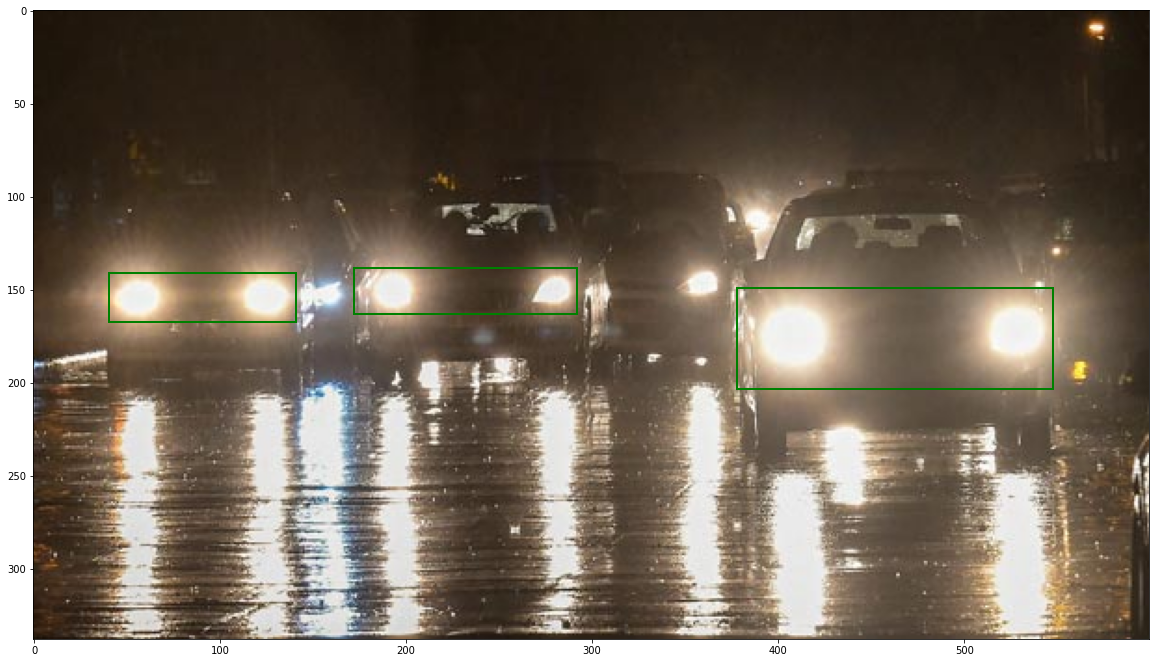

In [20]:
import matplotlib
f, axarr = plt.subplots(1,1, figsize=(20, 20))
axarr.imshow(orig1_rgb)
for i in range(len(coupleminx)):
    current_minx = coupleminx[i]
    current_maxx = couplemaxx[i]
    current_miny = coupleminy[i]
    current_maxy = couplemaxy[i]
    delta_x = current_maxx - current_minx
    delta_y = current_maxy - current_miny
    axarr.add_patch( matplotlib.patches.Rectangle((current_minx, current_miny), delta_x, delta_y, fc ='none', ec='g', lw = 2))